## Import Packages And Define Functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#### Import TALib Only If Necessary

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4428    0  4428    0     0  15679      0 --:--:-- --:--:-- --:--:-- 15702
100  517k  100  517k    0     0   654k      0 --:--:-- --:--:-- --:--:--  654k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4408    0  4408    0     0   8256      0 --:--:-- --:--:-- --:--:--  8270
100  392k  100  392k    0     0   383k      0  0:00:01  0:00:01 --:--:-- 3765k


In [ ]:
def annual_num_transaction(position):
    return sum(np.where(position != position.shift(1), 1, 0)) / len(position) * 252.

def annual_return(returns):
    return returns.mean() * 252.

def annual_volatility(returns):
    return returns.std() * (252. ** 0.5)

def cum_return(returns):
    return list(np.exp(returns.cumsum()))[-1]

def max_drawdown(returns):
    cum_returns = np.exp(returns.cumsum())
    cum_max = cum_returns.cummax()
    return ((cum_max - cum_returns) / cum_max).max()

def information_ratio(strategy_return, benchmark_return):
    track_error = annual_volatility(strategy_return - benchmark_return)
    if track_error < 1e-9:
        return 0.
    else:
        return (annual_return(strategy_return) - annual_return(benchmark_return)) / track_error

## Data Cleaning

In [ ]:
!pip install yfinance
import yfinance as yf

In [ ]:
code = [
    "^GSPC",
    "AAPL",
    "JPM",
    "GOOGL",
    "000300.SS", #HS300
    "600887.SS", #YLGF
    "600519.SS", #GZMT
    "600897.SS", #XMKG
    "601601.SS", #ZGTB
    "600188.SS", #YKNY
    "601318.SS", #ZGPA
    "600900.SS", #CJDL
    "600000.SS", #PFYH
    "002460.SZ", #GFLY
]
data_train = yf.download("^GSPC", start = "2007-01-01", end = "2023-01-01", auto_adjust = False)
data_train["close"] = data_train["Adj Close"]
data_train["open"] = data_train["Open"]
data_train["high"] = data_train["High"]
data_train["low"] = data_train["Low"]
data_train["return"] = np.log(data_train["close"] / data_train["close"].shift(1))
data_test = yf.download("^GSPC", start = "2022-01-01", auto_adjust = False)
data_test["close"] = data_test["Adj Close"]
data_test["open"] = data_test["Open"]
data_test["high"] = data_test["High"]
data_test["low"] = data_test["Low"]
data_test["return"] = np.log(data_test["close"] / data_test["close"].shift(1))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Strategy

In [ ]:
short_windows = [2, 4, 9, 19]
long_windows = [65, 125, 245]
up_stds = [0., 0.5, 1., 1.5, 2.0]
down_stds = [0., 0.5, 1., 1.5, 2.0]
transaction_cost = 0.
# max history data needed
look_back_window = 365
# backtest for 24 months
backtest_length = 365 * 2
backtest_launch_points = [
    # "2007-12-31",
    # "2009-12-31",
    # "2011-12-31",
    "2013-12-31",
    "2016-12-31",
    "2019-12-31",
    "2021-12-31",
    ]
performance = pd.DataFrame(columns = ["short_window",
                                      "long_window",
                                      "up_std",
                                      "down_std",
                                      "launch_point",
                                      "num_transaction_per_year",
                                      "annual_return",
                                      "annual_vol",
                                      "cum_return",
                                      "max_drawdown",
                                      "information_ratio"
                                      ])
for launch_point in backtest_launch_points:
    new_row = pd.DataFrame({
        "short_window": 0,
        "long_window": 0,
        "up_std": 0,
        "down_std": 0,
        "launch_point": launch_point,
        "num_transaction_per_year": 0,
        "annual_return": annual_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "annual_vol": annual_volatility(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "cum_return": cum_return(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "max_drawdown": max_drawdown(data_train[pd.to_datetime(launch_point):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]["return"]),
        "information_ratio": 0
        }, index = [0])
    performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
def dual_moving_average(short_window, long_window, up_std, down_std, df, launch_point, look_back_window, backtest_length, launch_position):
    dataframe = df.copy(deep = True)
    dataframe = dataframe[(pd.to_datetime(launch_point) - pd.to_timedelta(look_back_window, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    # dataframe[f"SMA_{short_window}"] = dataframe["close"].ewm(span = short_window).mean()
    dataframe[f"SMA_{short_window}"] = dataframe["close"].rolling(short_window).mean()
    # dataframe[f"SMA_{long_window}"] = dataframe["close"].ewm(span = long_window).mean()
    dataframe[f"SMA_{long_window}"] = dataframe["close"].rolling(long_window).mean()
    # dataframe[f"std_{short_window}"] = dataframe["close"].ewm(short_window).std()
    dataframe[f"std_{short_window}"] = dataframe["close"].rolling(short_window).std()
    # dataframe[f"std_{long_window}"] = dataframe["close"].ewm(long_window).std()
    dataframe[f"std_{long_window}"] = dataframe["close"].rolling(long_window).std()
    dataframe[f"position_strategy"] = launch_position
    # set index to be 0, 1, 2, ...
    dataframe["date"] = dataframe.index
    dataframe.index = range(len(dataframe))
    # for static stop loss
    open_price = 0.
    # when launch point is not a business day
    while len(dataframe[dataframe["date"] == launch_point].index.values) == 0:
        launch_point = str(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d"))
    launch_point_index = dataframe[dataframe["date"] == launch_point].index.values[0]
    # add extra row for forecast purpose
    last_date = pd.to_datetime(dataframe.loc[len(dataframe) - 1, "date"])
    dataframe.loc[len(dataframe), "date"] = last_date + pd.to_timedelta(1, unit = "d")
    # strategy logic
    for i in range(launch_point_index + 1, len(dataframe)):
        if dataframe.loc[i - 1, f"position_strategy"] == 0:
            if dataframe.loc[i - 1, f"SMA_{short_window}"] > (dataframe.loc[i - 1, f"SMA_{long_window}"] + up_std * dataframe.loc[i - 1, f"std_{long_window}"]):
                dataframe.loc[i, f"position_strategy"] = 1
                open_price = dataframe.loc[i, "open"]
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
        else:
            # if (dataframe.loc[i - 1, f"SMA_{short_window}"] < (dataframe.loc[i - 1, f"SMA_{long_window}"] - down_std * dataframe.loc[i - 1, f"std_{long_window}"])) | (dataframe.loc[i - 1, "low"] < open_price):
            if dataframe.loc[i - 1, f"SMA_{short_window}"] < (dataframe.loc[i - 1, f"SMA_{long_window}"] - down_std * dataframe.loc[i - 1, f"std_{long_window}"]):
                dataframe.loc[i, f"position_strategy"] = 0
                open_price = 0.
            else:
                dataframe.loc[i, f"position_strategy"] = dataframe.loc[i - 1, f"position_strategy"]
    dataframe[f"return_strategy"] = dataframe[f"position_strategy"] * dataframe["return"]
    # set index back to date
    dataframe.set_index("date", inplace = True)
    dataframe_drop = dataframe[(pd.to_datetime(launch_point) + pd.to_timedelta(1, unit = "d")):(pd.to_datetime(launch_point) + pd.to_timedelta(backtest_length, unit = "d"))]
    return dataframe_drop

## Train

In [ ]:
for short_window in short_windows:
    for long_window in long_windows:
        for up_std in up_stds:
            for down_std in down_stds:
                for launch_point in backtest_launch_points:
                    output_train = dual_moving_average(short_window, long_window, up_std, down_std, data_train, launch_point, look_back_window, backtest_length, 0)
                    # drop the added last row
                    output_train = output_train.dropna()
                    new_row = pd.DataFrame({
                        "short_window": short_window,
                        "long_window": long_window,
                        "up_std": up_std,
                        "down_std": down_std,
                        "launch_point": launch_point,
                        "num_transaction_per_year": annual_num_transaction(output_train[f"position_strategy"]),
                        "annual_return": annual_return(output_train[f"return_strategy"]),
                        "annual_vol": annual_volatility(output_train[f"return_strategy"]),
                        "cum_return": cum_return(output_train[f"return_strategy"]),
                        "max_drawdown": max_drawdown(output_train[f"return_strategy"]),
                        "information_ratio": information_ratio(output_train[f"return_strategy"], output_train["return"])
                    }, index = [0])
                    performance = pd.concat([performance, new_row], ignore_index = True)

In [ ]:
# calculate average information ration through all bt launch points
tmp = pd.DataFrame(columns = ["short_window",
                              "long_window",
                              "up_std",
                              "down_std",
                              "avg_information_ratio"
                              ])
for short_window in short_windows:
    for long_window in long_windows:
        for up_std in up_stds:
            for down_std in down_stds:
                new_row = pd.DataFrame({
                    "short_window": short_window,
                    "long_window": long_window,
                    "up_std": up_std,
                    "down_std": down_std,
                    "avg_information_ratio": performance[(performance["short_window"] == short_window) &
                     (performance["long_window"] == long_window) &
                      (performance["up_std"] == up_std) &
                       (performance["down_std"] == down_std)][["information_ratio"]].mean().values[0]
                    }, index = [0])
                tmp = pd.concat([tmp, new_row], ignore_index = True)
performance = pd.merge(performance, tmp, on = ["short_window", "long_window", "up_std", "down_std"], how = "left")

In [ ]:
performance.sort_values(by = ["avg_information_ratio", "short_window", "long_window", "up_std", "down_std", "launch_point"], ascending = False)

,short_window,long_window,up_std,down_std,launch_point,num_transaction_per_year,annual_return,annual_vol,cum_return,max_drawdown,information_ratio,avg_information_ratio
1135,19,245,0.5,1.0,2021-12-31,1.041322,0.000000,0.000000,1.000000,0.000000,0.822636,0.250661
1134,19,245,0.5,1.0,2019-12-31,1.039175,0.699134,0.651219,3.840323,0.407619,-0.720824,0.250661
1133,19,245,0.5,1.0,2016-12-31,1.561983,0.233173,0.449447,1.564929,0.483027,0.538644,0.250661
1132,19,245,0.5,1.0,2013-12-31,1.235294,1.033218,0.710253,5.327222,0.550491,0.362188,0.250661
1131,19,245,0.5,0.5,2021-12-31,1.041322,0.000000,0.000000,1.000000,0.000000,0.822636,0.207662
...,...,...,...,...,...,...,...,...,...,...,...,...
780,9,125,1.5,2.0,2013-12-31,2.434783,0.750901,0.679595,3.433648,0.550491,-1.318722,-0.747714
3,0,0,0,0,2021-12-31,0,-0.354596,0.476513,0.710397,0.389154,0,NaN
2,0,0,0,0,2019-12-31,0,0.715268,0.650704,3.972699,0.407619,0,NaN
1,0,0,0,0,2016-12-31,0,0.121853,0.523922,1.264911,0.663303,0,NaN


## Backtest

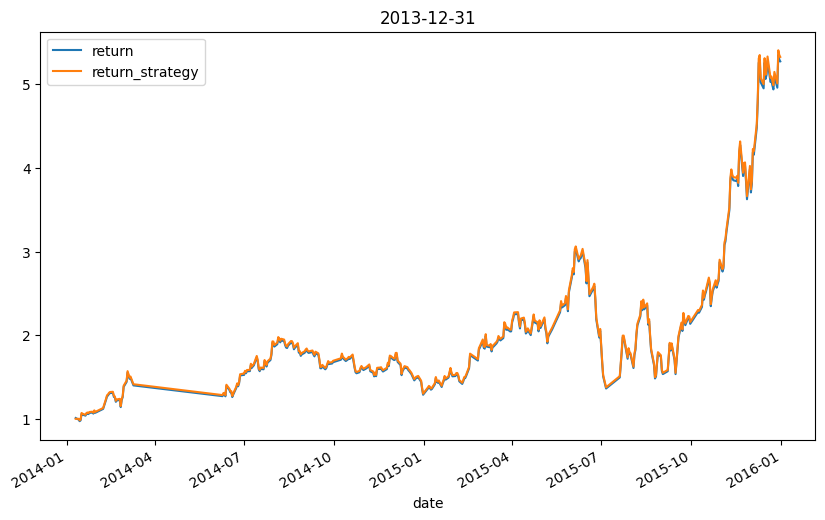

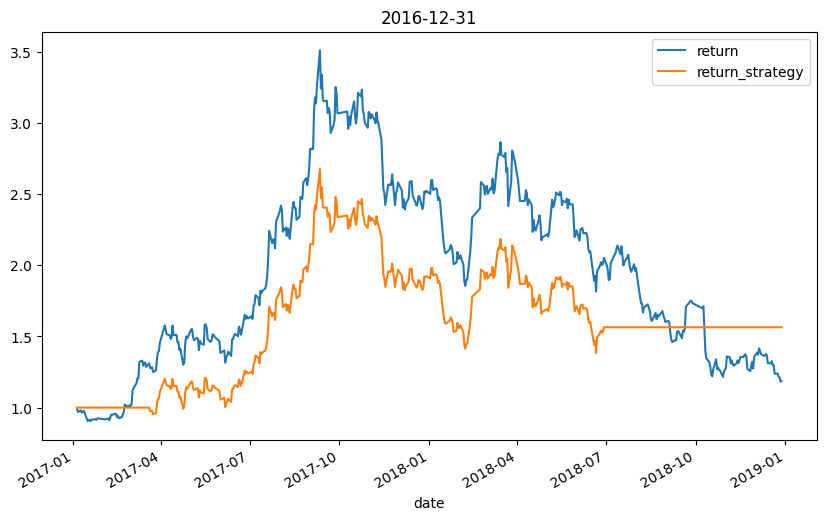

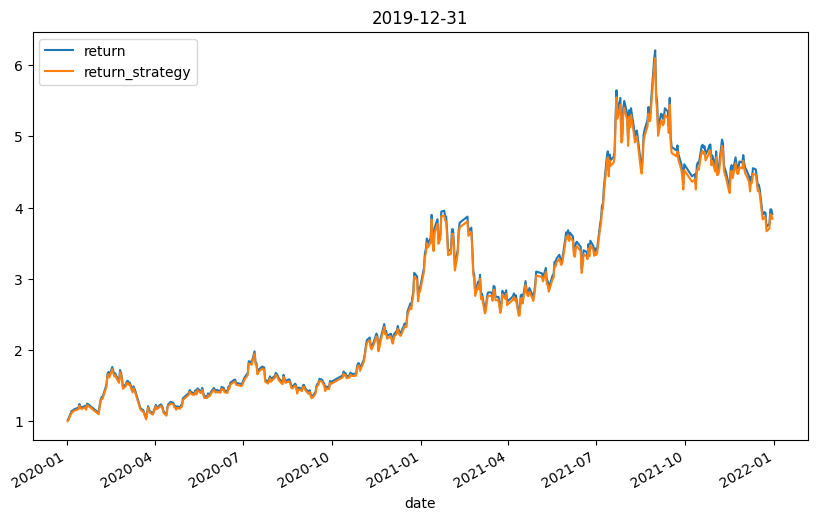

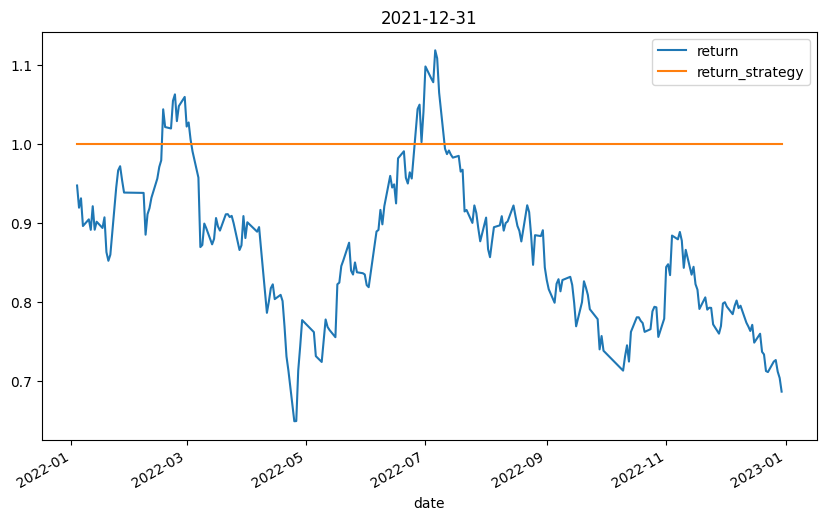

In [ ]:
# short_window, long_window, up_std, down_std = 19, 65, 0.0, 2.0 #GSPC
# short_window, long_window, up_std, down_std = 19, 245, 0.5, 2.0 #YLGF
short_window, long_window, up_std, down_std = 19, 245, 0.5, 1.0 #GFLY
for launch_point in backtest_launch_points:
    output_backtest = dual_moving_average(short_window, long_window, up_std, down_std, data_train, launch_point, look_back_window, backtest_length, 0)
    # drop the added last row
    output_backtest = output_backtest.dropna()
    output_backtest[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
    # output_backtest[["open_price"]].plot(figsize=(10, 6))
    # output_backtest[f"position_strategy"].plot(secondary_y = True, legend = "position")
    # output_backtest[["close"]].plot(secondary_y = True, legend = "close")

## Forecast

In [ ]:
# short_window, long_window, up_std, down_std = 19, 65, 0.0, 2.0 #GSPC
# short_window, long_window, up_std, down_std = 19, 245, 0.5, 2.0 #YLGF
short_window, long_window, up_std, down_std = 19, 245, 0.5, 1.0 #GFLY
launch_point = "2023-01-01"
# launch_point = "2024-03-01" #^GSPC
# launch_point = "2024-03-06" #YLGF
# launch_point = "2024-02-25" #GFLY
output_test = dual_moving_average(short_window, long_window, up_std, down_std, data_test, launch_point, look_back_window, backtest_length, 0)
new_row = {
    "short_window": short_window,
    "long_window": long_window,
    "up_std": up_std,
    "down_std": down_std,
    "launch_point": launch_point,
    "num_transaction_per_year": annual_num_transaction(output_test[f"position_strategy"]),
    "annual_return": annual_return(output_test[f"return_strategy"]),
    "annual_vol": annual_volatility(output_test[f"return_strategy"]),
    "cum_return": cum_return(output_test[f"return_strategy"]),
    "max_drawdown": max_drawdown(output_test[f"return_strategy"]),
    "information_ratio": information_ratio(output_test[f"return_strategy"], output_test["return"])
}

In [ ]:
new_row

{'short_window': 19,
 'long_window': 245,
 'up_std': 0.5,
 'down_std': 1.0,
 'launch_point': '2023-01-01',
 'num_transaction_per_year': 0.8719723183391004,
 'annual_return': 0.0,
 'annual_vol': 0.0,
 'cum_return': nan,
 'max_drawdown': 0.0,
 'information_ratio': 1.3436027824534715}

<Axes: >

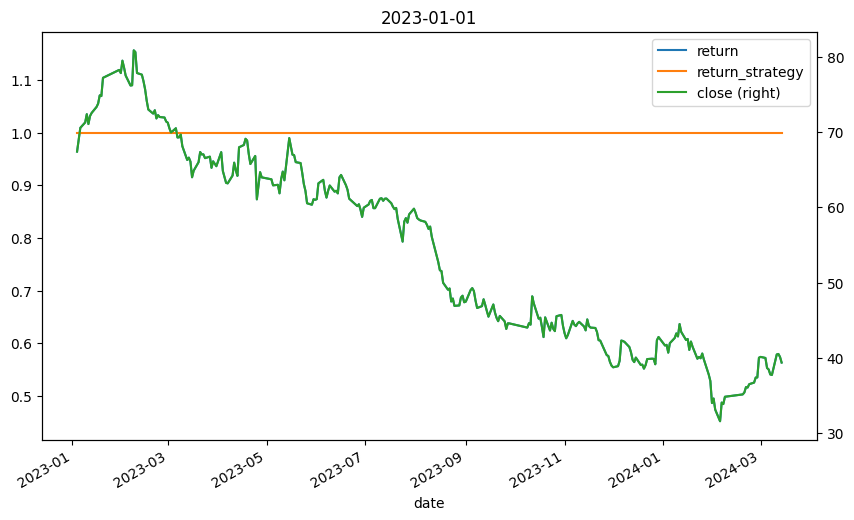

In [ ]:
output_test[["return", f"return_strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 6), title = launch_point)
# output_test[["close", f"SMA_{short_term}", f"SMA_{long_term}"]].plot(figsize=(10, 6))
# output_test[f"position_strategy"].plot(secondary_y = True, legend = "position")
output_test["close"].plot(secondary_y = True, legend = "close")

In [ ]:
output_test.tail(10)

,open,close,high,low,volume,code,return,SMA_19,SMA_245,std_19,std_245,position_strategy,return_strategy
date,,,,,,,,,,,,,
2024-03-04,40.43,40.02,41.35,39.71,361729.0,002460,-0.003492,36.026842,52.155224,2.345040,10.965826,0.0,-0.0
2024-03-05,39.50,38.69,39.57,38.50,289938.0,002460,-0.033798,36.117895,52.022327,2.415803,10.930708,0.0,-0.0
2024-03-06,38.27,38.49,39.01,37.95,215003.0,002460,-0.005183,36.352632,51.891633,2.418339,10.900135,0.0,-0.0
2024-03-07,38.79,37.83,39.10,37.80,221647.0,002460,-0.017296,36.520526,51.760612,2.403522,10.875318,0.0,-0.0
2024-03-08,37.82,37.76,38.50,37.40,191186.0,002460,-0.001852,36.762632,51.626939,2.274423,10.845147,0.0,-0.0
2024-03-11,38.25,40.48,40.68,38.25,500517.0,002460,0.069558,37.228947,51.509388,2.059592,10.809042,0.0,0.0
2024-03-12,41.38,40.55,41.60,40.08,368945.0,002460,0.001728,37.568421,51.392041,2.046733,10.771103,0.0,0.0
2024-03-13,40.60,40.16,40.89,39.93,214535.0,002460,-0.009664,37.897895,51.271551,1.923546,10.730724,0.0,-0.0
2024-03-14,40.01,39.41,40.68,39.13,262197.0,002460,-0.018852,38.136842,51.154367,1.804839,10.702704,0.0,-0.0
